In [3]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from pyomo.environ import *
from pyomo.opt import SolverFactory

%matplotlib inline

# Network Optimization

In this part, we will be modeling a network optimization problem based on routers. The main goal will be to find the optimal path from one router to the target router. For our problem we will have routers connected by edges, where those edges will be half-duplex (can send information or flow both ways but only in one direction). Moreover, each edge will have an associated cost which in the real world is the length of the path (the longer, the more time it will take, therefore more cost); and also a capacity related to the bandwidth in a real scenario.

So now that we have a good understanding on the problem we will write the model mathematically and then solve it with pyomo. But first, let's simulate the data.

For the simulation of the data we will get them form a probability distribution so we can scale the problem better. First of all we will get 2 different values to describe the network.

- N: this will be a vector with the labels of the routers. It will go from 0 to N.
- R: it will be the 3d matrix containing the characterstics of every node. The shape will be (NxNx3)
    - The first two dimensions are related to the edge from the i router to the j router. Take care that this will be a symmetric matrix as the edges are half duplex (connected both ways).
    - Regarding to the last dimension it will be an array of 3 values.
        1. The first value will be if the two routers are connected, that is if the edge exists.
        2. The second will be the cost associated to that edge
        3. And the last one the capacity of the edge.

Now, with this set up we will create the functions that will return the simulation of the network.

In [20]:
def generate_natural_random_value(mean, sd):
   value = np.round(np.random.normal(mean, sd)).astype(int)
   return value if value >= 0 else 0
   
def generate_network(n_nodes, p_route=0.15, mean_cost=5, sd_cost=2, mean_capacity=30, sd_capacity=10, seed=42):
   N = np.arange(0, n_nodes) 

   np.random.seed(seed)
   
   # Generate upper triangle with binary values
   random_matrix = np.random.choice([0, 1], size=(n_nodes, n_nodes), p=[1 - p_route, p_route])

   # Set diagonal elements to zero as we don't want recursion
   np.fill_diagonal(random_matrix, 0)

   lower_triangle = np.tril(random_matrix.T, k=-1)

   R = np.zeros((n_nodes, n_nodes, 3))

   # Combine upper and lower triangles to form the symmetric matrix
   R[:, :, 0] = lower_triangle

   rows, cols = np.where(R[:, :, 0] == 1)
   for row, col in zip(rows, cols):
      cost = generate_natural_random_value(mean_cost, sd_cost)
      capacity = generate_natural_random_value(mean_capacity, sd_capacity)

      R[row][col][1] = cost
      R[row][col][2] = capacity

   # duplicate all values to be symetric
   upper_triangle = lower_triangle.T

   # Combine upper and lower triangles to form the symmetric matrix
   for i in range(3):
      R[:, :, i] = R[:, :, i] + R[:, :, i].T
   
   return N, R


N, R = generate_network(20)
print(R[:, :, 0])


[[0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0.]
 [0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

We will be simulating a network with 20 routers. And also we can see that the matrix is symmetric. Moreover, the diagonal is 0 as we do not allow self routing.

Now, let's plot it to see it better.

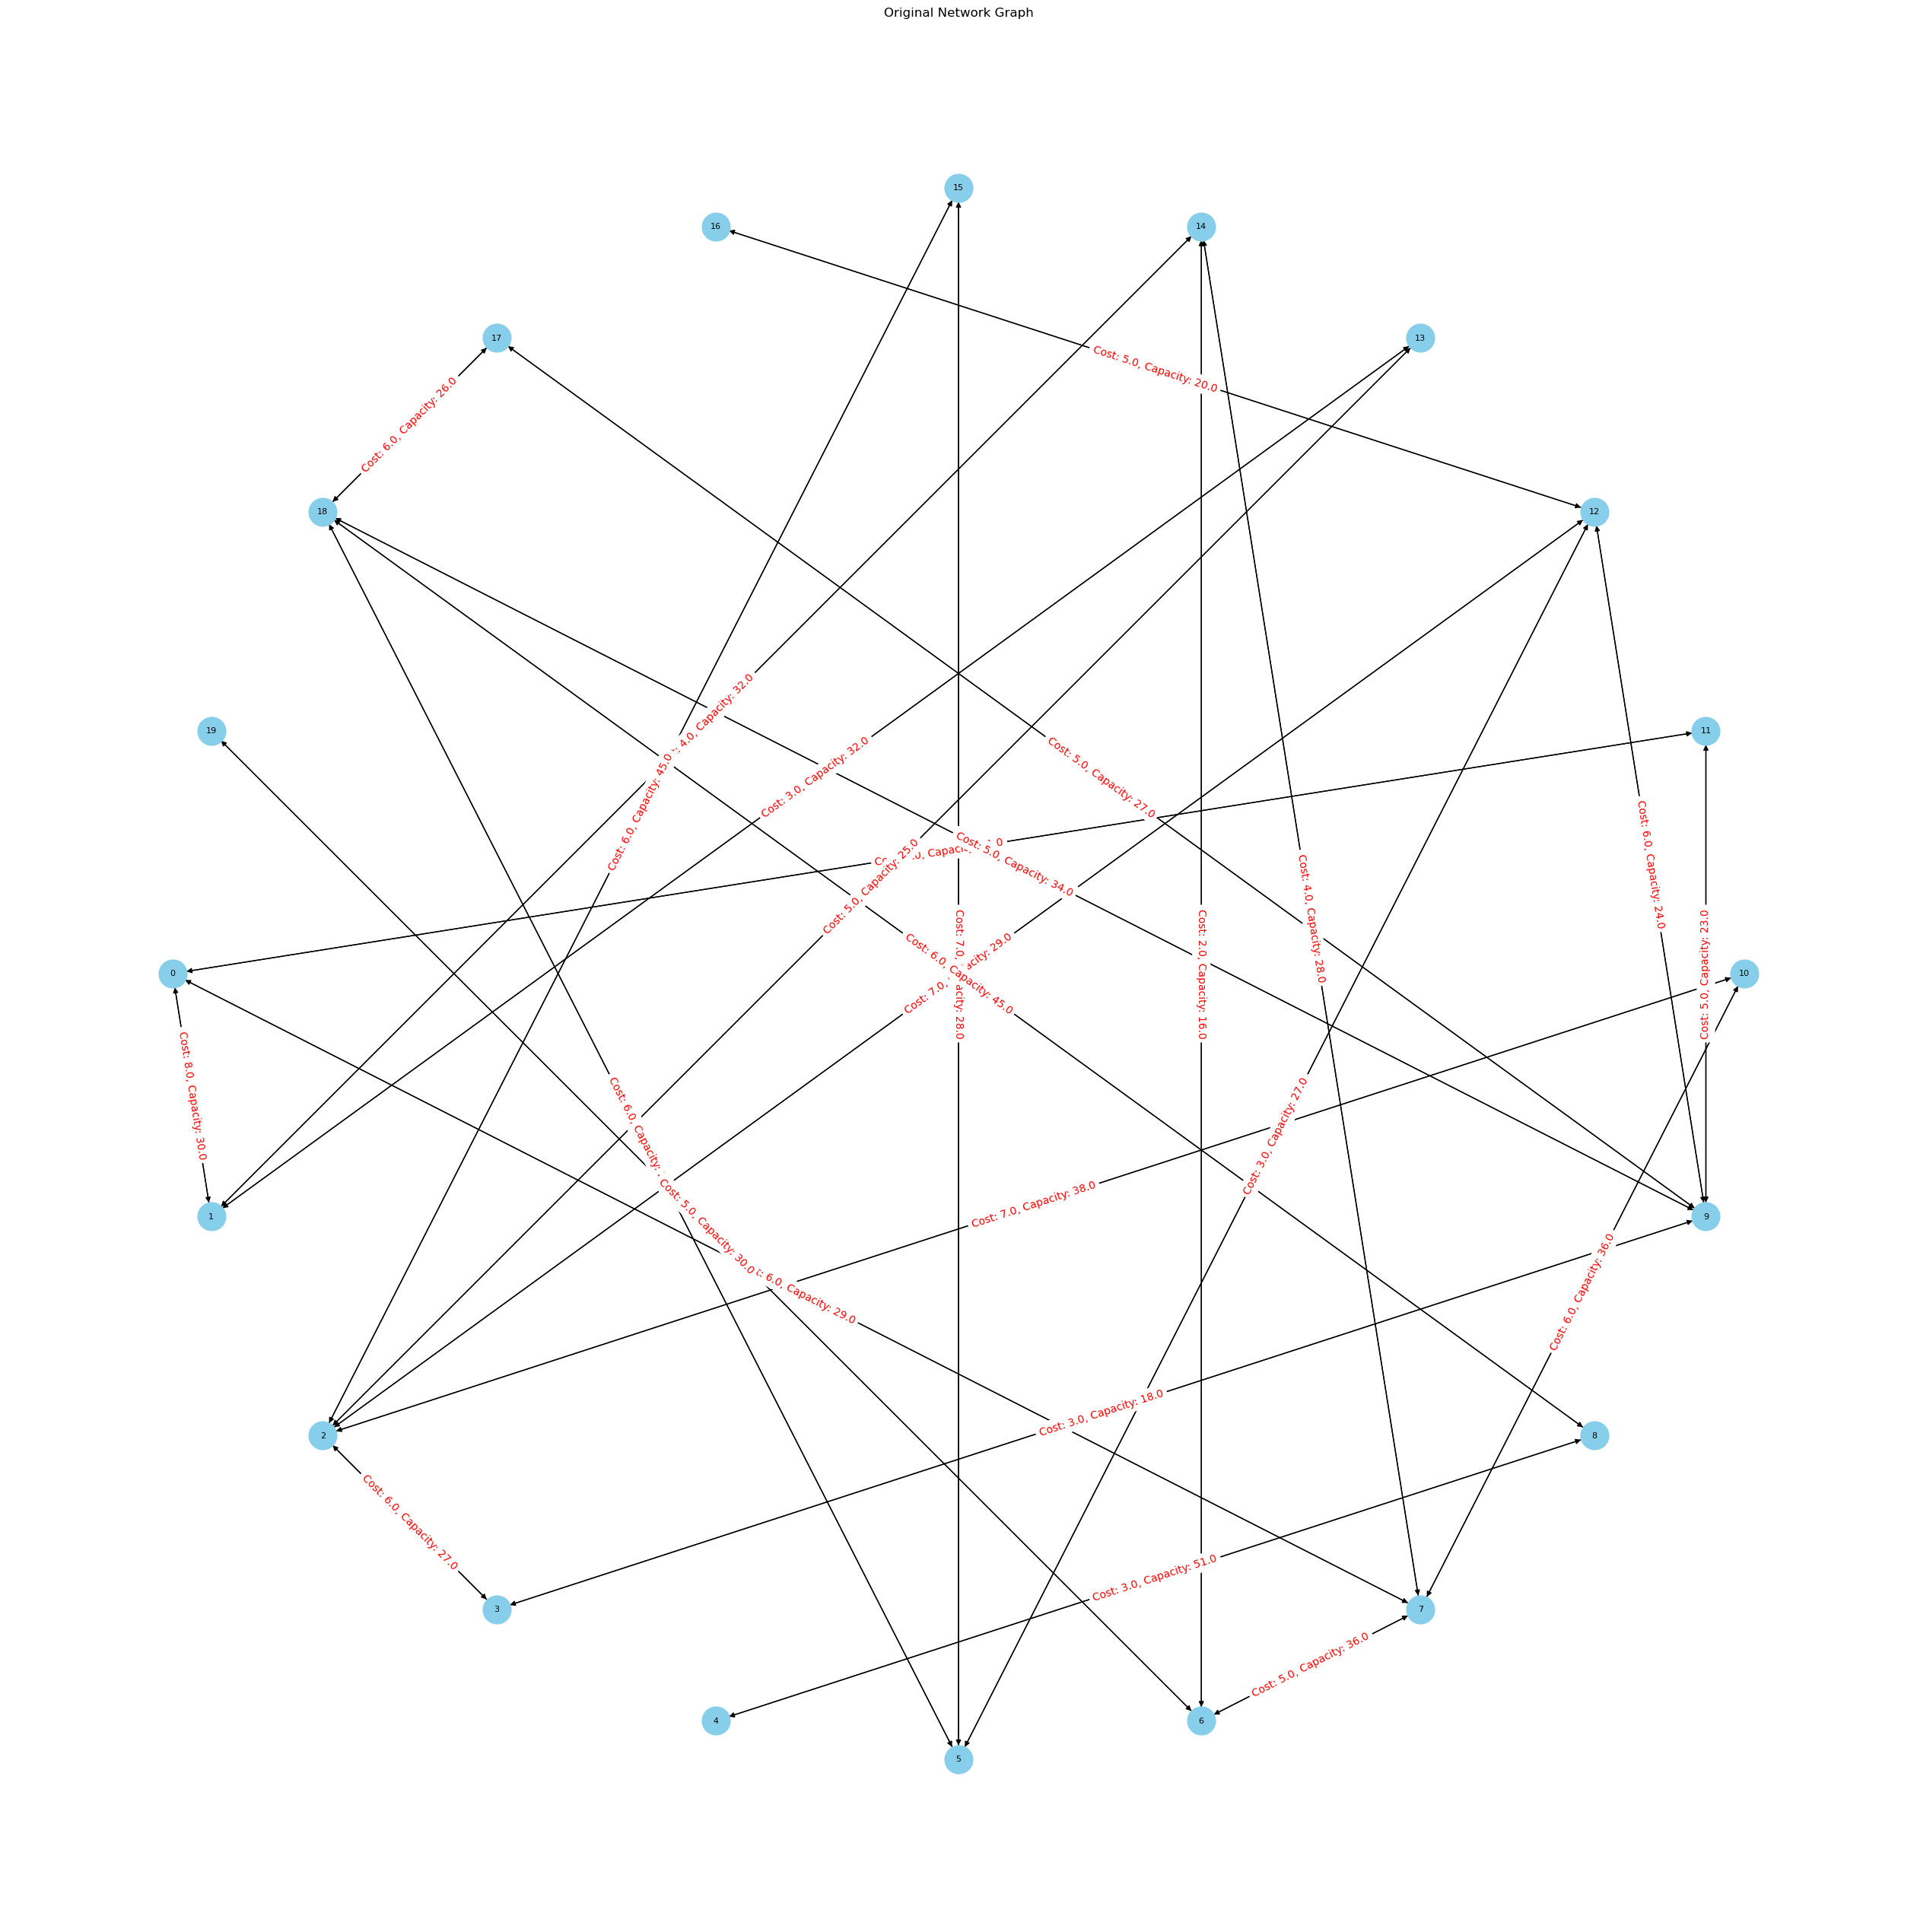

In [21]:

# Create a directed graph
G = nx.DiGraph()

# Add nodes to the graph
G.add_nodes_from(N)

# Add edges to the graph based on the matrix
for i in range(len(N)):
    for j in range(len(N)):
        if R[i, j, 0] == 1:  # Check if there's a route (assuming 1 represents a connection)
            cost = R[i, j, 1]
            capacity = R[i, j, 2]
            G.add_edge(N[i], N[j], cost=cost, capacity=capacity)

# Visualize the graph
pos = nx.shell_layout(G)

labels_cost = nx.get_edge_attributes(G, 'cost')
labels_capacity = nx.get_edge_attributes(G, 'capacity')
labels = {(i, j): f"Cost: {labels_cost[(i, j)]}, Capacity: {labels_capacity[(i, j)]}" for i, j in labels_cost}

plt.figure(figsize=(25, 25))  # Adjust the figure size here
nx.draw(G, pos, with_labels=True, node_size=700, node_color='skyblue', font_color='black', font_size=8)
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels, font_color='red')

plt.title('Original Network Graph')
plt.show()


Here we can see the full network. Everything is correctly set up and the cost and the capacity are properly random. Now that we have a base network to work with, let's formulate the optimization model.

## Mathematical Formulation

Sets:
- N: this will be the different routers on the network. For this example, we will be using 0 to N routers.

Parameters: 
- $connected_{ij}$ = (binary number) if the edge from i to j is established (i, j) ∈ (NxN) 
- $cost_{ij}$ = (non negative integer) cost of edge (i,j) ∈ (NxN) 
- $capacity_{ij}$ = (non negative integer) capacity of edge (i,j) ∈ (NxN) 

Decision Variables:
- $x_{ij}$ = (non negative integer) amount of flow on edge (i,j) ∈ (NxN)
- $y_{ij}$ = (non negative integer) auxiliary variable to make the half-duplex constraint possible (i, j) ∈ (NxN)

Objective Function:  
$$min(∑_{(i,j)∈(NxN)}{c_{ij} * x_{ij}})$$

Constraints:
- Capacity constraints: the amount of flow of the edge cannot be higher than the capacity
$$x_{ij} ≤ capacity_{ij} ∀(i,j) ∈ A$$

- Flow conservation: what comes in to a router must be the same than what comes out except from the sink (output) and the source (input)
$$∑_j x_{ij} - ∑_k x_{ki} = 0 if \forall i ∈ N, i ≠ source, sink$$

- One-way flow constraint: if there is a connection between two different nodes, then just one direction can be used (half-duplex)
$$x_{ij}  ≤ y_{j, i} if connected_{ij} == 1 \forall (i,j) ∈ (NxN)$$

- Source flow: the amount of flow going out from the source must be equal to the total demand
$$∑_j x_{source,j} == total_{demand} $$

- Sink flow: the amount of flow going in to the sink must be equal to the total demand
$$∑_j x_{j,sink} == total_{demand} $$

- Source in null: restrict the source to not be able to receive flow
$$∑_j x_{j, source} == 0 $$

- Sink in null: restrict the sink to not be able to send flow
$$∑_j x_{sink, j} == 0 $$

## Model Programming

Now that we have the model mathematically defined, let's create do it in pyomo. For this example we will be using the network we had simulated above, and we will be sending 30 units from the router 9 to the router 2. This is to see if the network behaves correctly and can send though multiple paths, and select the ones with the lowest cost.

In [22]:

# Define constants
total_demand = 30

source = 9
sink = 2

# Create concrete model
model = ConcreteModel()

# Define sets
model.N = Set(initialize=tuple(N))

# Define parameters
model.connected = Param(model.N, model.N, initialize=lambda model, i, j: R[i, j, 0])
model.cost = Param(model.N, model.N, initialize=lambda model, i, j: R[i, j, 1])
model.capacity = Param(model.N, model.N, initialize=lambda model, i, j: R[i, j, 2])

# Define decision variables
model.x = Var(model.N, model.N, domain=NonNegativeIntegers)
model.y = Var(model.N, model.N, domain=NonNegativeIntegers)

# Define objective function
model.obj = Objective(expr=sum(model.cost[i, j] * model.x[i, j] for i in model.N for j in model.N), sense=minimize)

# Define capacity constraints
model.capacity_constraints = ConstraintList()
for i in model.N:
    for j in model.N:
        model.capacity_constraints.add(model.x[i, j] <= model.capacity[i, j])

# Define flow conservation constraints
model.flow_conservation = ConstraintList()
for i in model.N:
    if i not in {source, sink}:
        inflow = sum(model.x[k, i] for k in model.N if model.connected[k, i] == 1)
        outflow = sum(model.x[i, k] for k in model.N if model.connected[k, i] == 1)
        model.flow_conservation.add(inflow - outflow == 0)

# Define non-negativity constraints for one-way flow
model.one_way_flow_constraints = ConstraintList()
for i in model.N:
    for j in model.N:
        if (i != j) and (model.connected[i, j] == 1):
            model.one_way_flow_constraints.add(model.x[i, j] <= model.y[j, i])

# Define source and sink flow constraints
model.source_flow = Constraint(expr=sum(model.x[source, j] for j in model.N if model.connected[source, j] == 1) == total_demand)
model.sink_flow = Constraint(expr=sum(model.x[i, sink] for i in model.N if model.connected[i, sink] == 1) == total_demand)

model.source_in_null = Constraint(expr=sum(model.x[j, source] for j in model.N if model.connected[j, source] == 1) == 0)
model.sink_out_null = Constraint(expr=sum(model.x[sink, j] for j in model.N if model.connected[sink, j] == 1) == 0)

# Solve the optimization problem
solver = SolverFactory('gurobi')
result = solver.solve(model)

# Display the results
print("Objective value:", model.obj())
print("Flow values:")
for i in model.N:
    for j in model.N:
        if (model.x[i, j].value != 0):
            print(f"x_{i}_{j} =", model.x[i, j].value)

Objective value: 318.0
Flow values:
x_3_2 = 18.0
x_9_3 = 18.0
x_9_12 = 12.0
x_12_2 = 12.0


So here we can see that the model has solved the problem correctly. It is sending flow though the lowest cost path fist and then though other alternative paths. We can see that the total flow is correct. But this is not really descriptive, so let's see it visually for better understanding.

## Interpretation of the solution

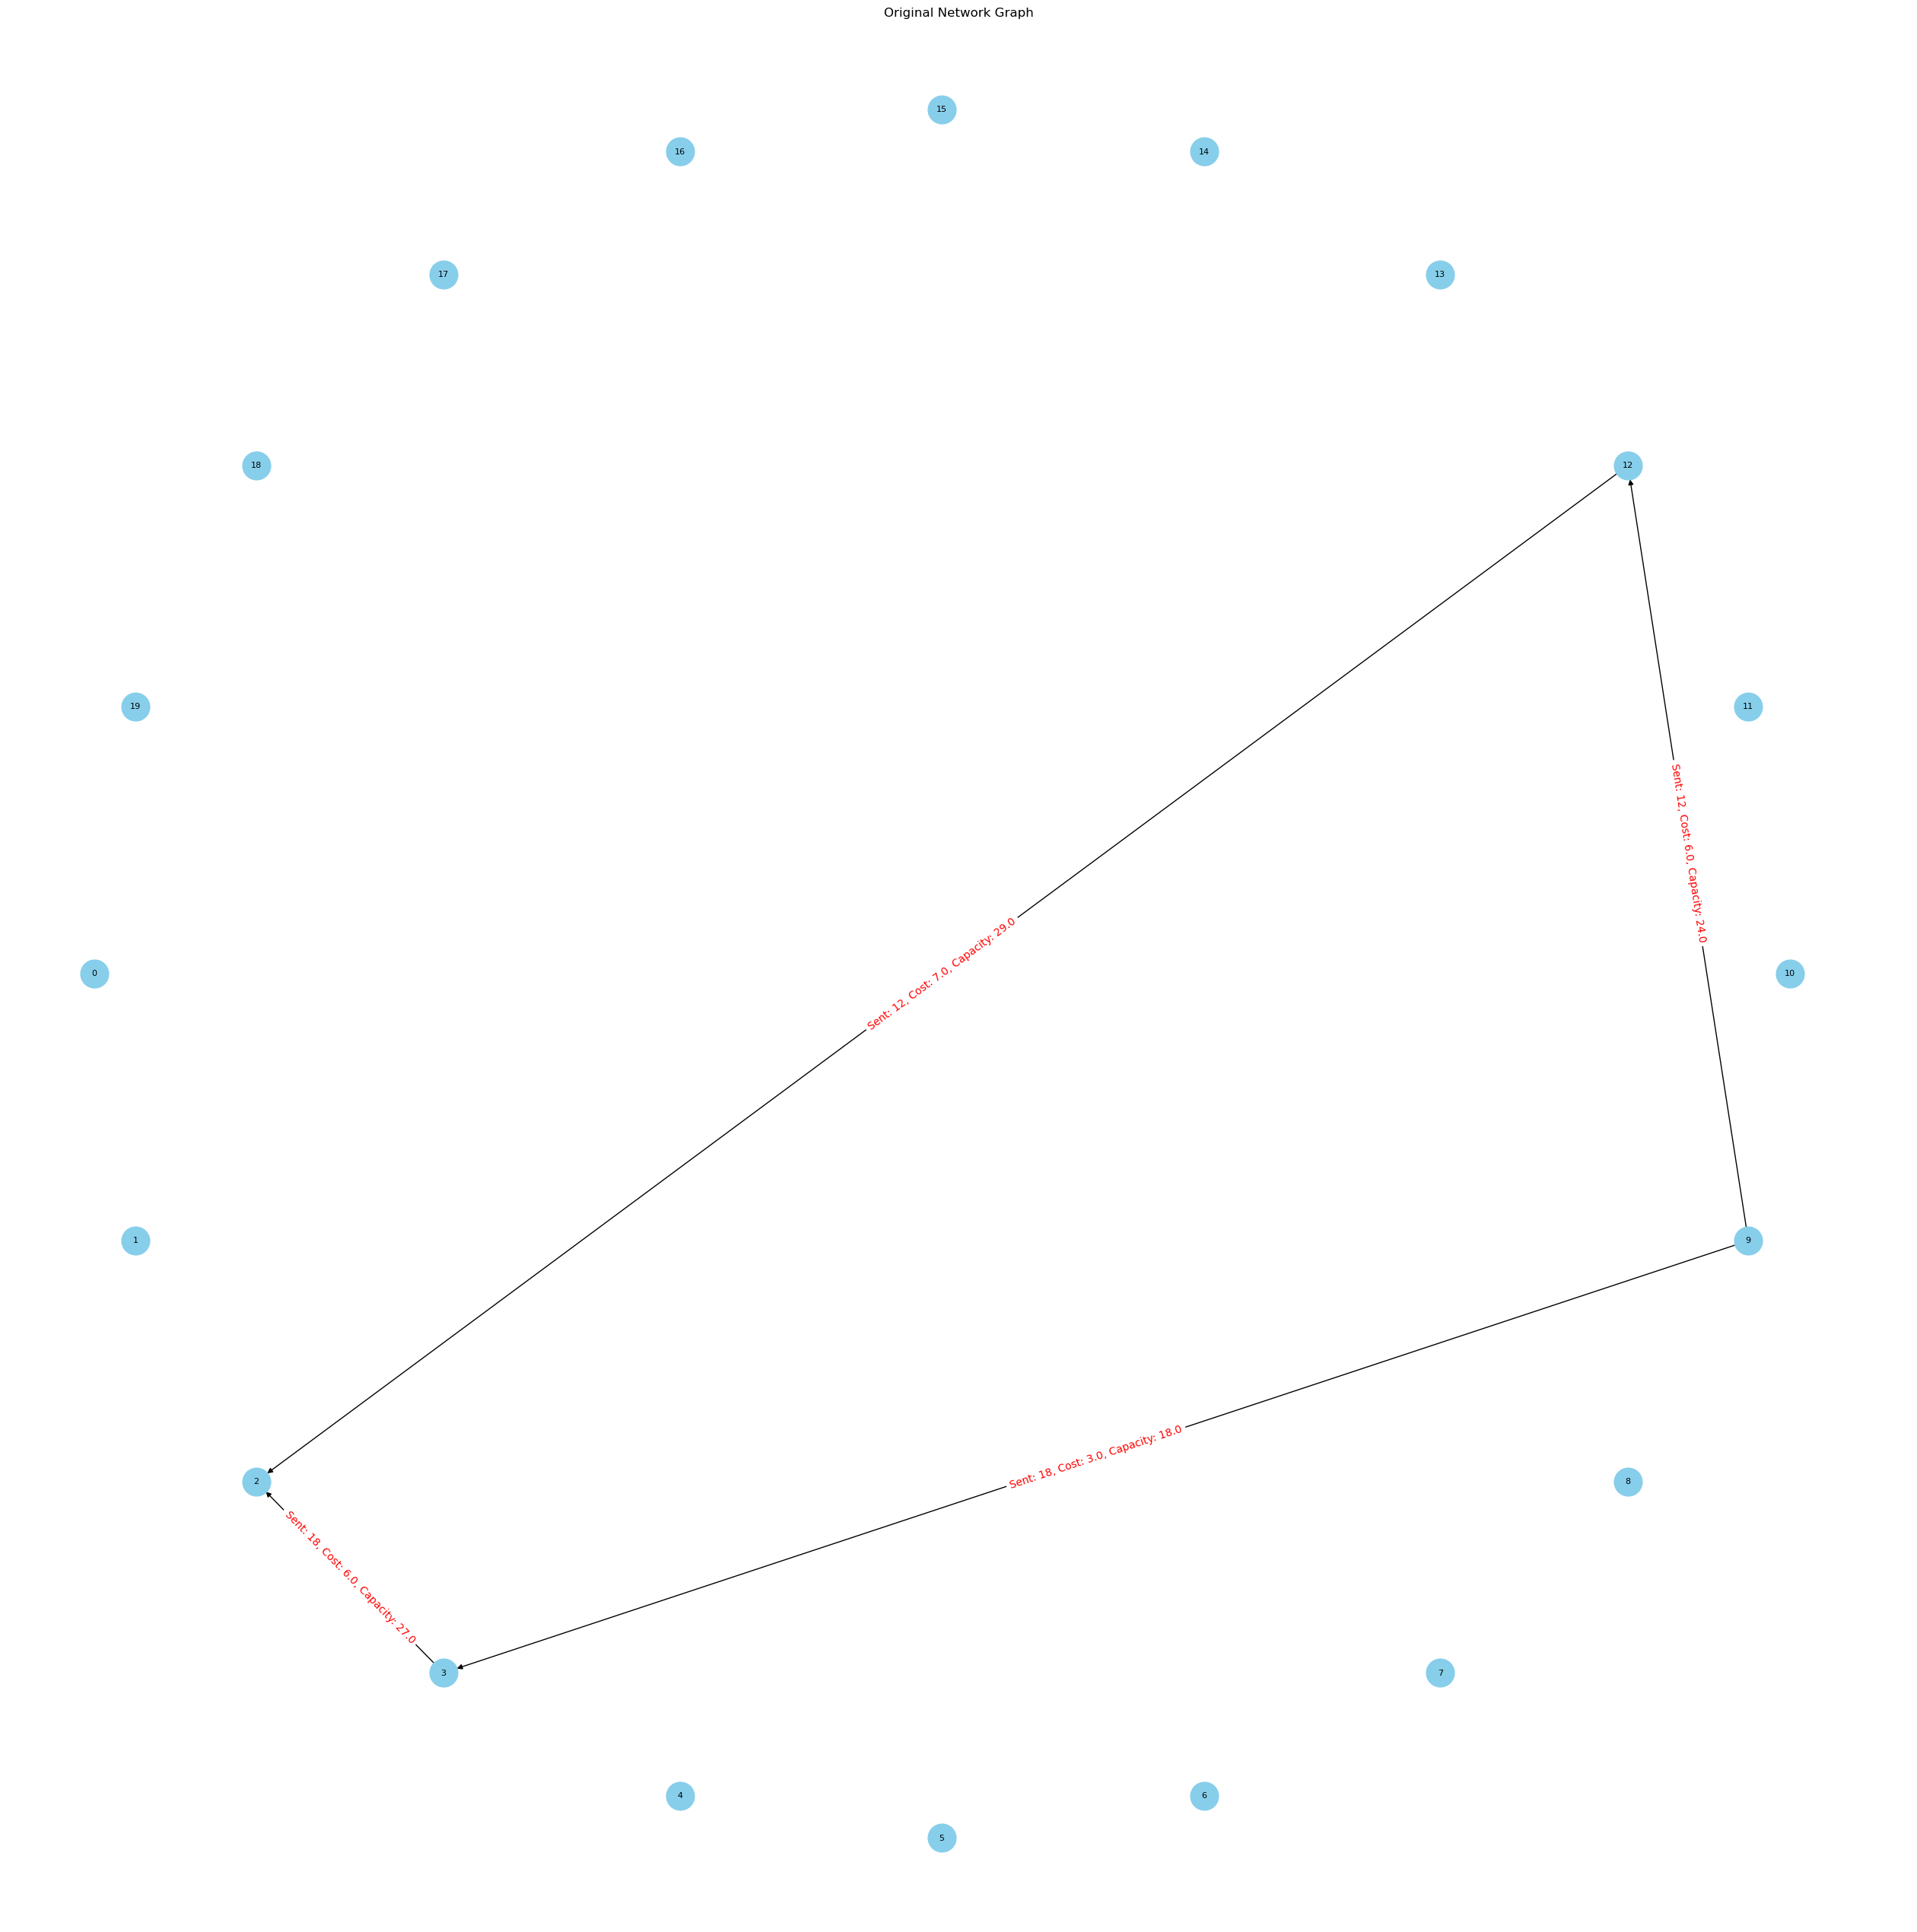

In [23]:
# Create a directed graph
G_optimized = nx.DiGraph()

# Add nodes to the graph
G_optimized.add_nodes_from(N)

# Add edges to the graph based on the matrix
for i in range(len(N)):
    for j in range(len(N)):
        optimized_flow = model.x[i, j].value

        if optimized_flow != 0:  
            G_optimized.add_edge(N[i], N[j], optimized_flow=optimized_flow)

# Visualize the graph
pos = nx.shell_layout(G_optimized)


labels_optimized_flow = nx.get_edge_attributes(G_optimized, 'optimized_flow')
edge_labels = {(i, j): f"Sent: {labels_optimized_flow[i, j]:.0f}, Cost: {R[i, j, 1]}, Capacity: {R[i, j, 2]}" for i, j in labels_optimized_flow}

# Plot the optimized flow on the edges
plt.figure(figsize=(25, 25))  # Adjust the figure size here
nx.draw(G_optimized, pos, with_labels=True, node_size=700, node_color='skyblue', font_color='black', font_size=8)
nx.draw_networkx_edge_labels(G_optimized, pos, edge_labels=edge_labels, font_color='red')

plt.title('Original Network Graph')
plt.show()

## Conclusions

So here we can see much better that it is sending thought the router 3 which is the best path and it is filling up the maxium capacity. Then it is sending though routers 18 and 12 which are the other low cost paths. We have correctly model a network problem which is useful to send packets though a network (in this case routers). This model can be used for other problems, such as logistics or resource optimization. And we have learned about creating constraints to adapt this type of network problems.

Now let's see the other type of problem. That is the non-linear optimization problme.

# 2

Sets:
- N: this will be the different routers on the network. For this example, we will be using 0 to N routers.

Parameters: 
- $connected_{ij}$ = (binary number) if the edge from i to j is established (i, j) ∈ (NxN) 
- $cost_{ij}$ = (non negative integer) cost of edge (i,j) ∈ (NxN) 
- $capacity_{ij}$ = (non negative integer) capacity of edge (i,j) ∈ (NxN) 

Decision Variables:
- $x_{ij}$ = (non negative integer) amount of flow on edge (i,j) ∈ (NxN)
- $y_{ij}$ = (non negative integer) auxiliary variable to make the half-duplex constraint possible (i, j) ∈ (NxN)

Objective Function:
$$min(∑_{(i,j)∈(NxN)}{(cost_{ij} * x_{ij}^2)} + (capacity_{ij} * x_{ij})^2)$$

Constraints:
- Capacity constraints: the amount of flow of the edge cannot be higher than the capacity
$$x_{ij} ≤ capacity_{ij}$$

- Flow conservation: what comes in to a router must be the same than what comes out except from the sink (output) and the source (input)
$$∑_j x_{ij} - ∑_k x_{ki} = 0 if \forall i ∈ N, i ≠ source, sink$$

- One-way flow constraint: if there is a connection between two different nodes, then just one direction can be used (half-duplex)
$$x_{ij}  ≤ y_{j, i} if connected_{ij} == 1 \forall (i,j) ∈ (NxN)$$

- Source flow: the amount of flow going out from the source must be equal to the total demand
$$∑_j x_{source,j} == total_{demand} $$

- Sink flow: the amount of flow going in to the sink must be equal to the total demand
$$∑_j x_{j,sink} == total_{demand} $$

- Source in null: restrict the source to not be able to receive flow
$$∑_j x_{j, source} == 0 $$

- Sink in null: restrict the sink to not be able to send flow
$$∑_j x_{sink, j} == 0 $$

In [101]:
# Define constants
total_demand = 10

source = 9
sink = 2

# Create concrete model
model = ConcreteModel()

# Define sets
model.N = Set(initialize=tuple(N))
model.T = Set(initialize=[1, 2])

# Define parameters
model.connected = Param(model.N, model.N, initialize=lambda model, i, j: R[i, j, 0])
model.cost = Param(model.N, model.N, initialize=lambda model, i, j: R[i, j, 1])
model.capacity = Param(model.N, model.N, initialize=lambda model, i, j: R[i, j, 2])

# Define decision variables
model.x = Var(model.N, model.N, domain=NonNegativeIntegers)
model.y = Var(model.N, model.N, domain=NonNegativeIntegers)
model.packet_type = Var(model.N, model.N, within=model.T)

# Define objective function
model.obj = Objective(expr=sum((((model.cost[i, j] * model.x[i, j]**2)) + (model.packet_type[i, j] * model.x[i, j])) for i in model.N for j in model.N), sense=minimize)

# Define capacity constraints
model.capacity_constraints = ConstraintList()
for i in model.N:
    for j in model.N:
        model.capacity_constraints.add((model.x[i, j]) <= model.capacity[i, j])

# Define flow conservation constraints
model.flow_conservation = ConstraintList()
for i in model.N:
    if i not in {source, sink}:
        inflow = sum(model.x[k, i] for k in model.N if model.connected[k, i] == 1)
        outflow = sum(model.x[i, k] for k in model.N if model.connected[k, i] == 1)
        model.flow_conservation.add(inflow - outflow == 0)

# Define non-negativity constraints for one-way flow
model.one_way_flow_constraints = ConstraintList()
for i in model.N:
    for j in model.N:
        if (i != j) and (model.connected[i, j] == 1):
            model.one_way_flow_constraints.add(model.x[i, j] <= model.y[j, i])

# Define source and sink flow constraints
model.source_flow = Constraint(expr=sum(model.x[source, j] for j in model.N if model.connected[source, j] == 1) == total_demand)
model.sink_flow = Constraint(expr=sum(model.x[i, sink] for i in model.N if model.connected[i, sink] == 1) == total_demand)

model.source_in_null = Constraint(expr=sum(model.x[j, source] for j in model.N if model.connected[j, source] == 1) == 0)
model.sink_out_null = Constraint(expr=sum(model.x[sink, j] for j in model.N if model.connected[sink, j] == 1) == 0)

# TODO package types

# Define a non-trivial constraint on the flow progression
model.flow_progression_constraints = ConstraintList()
for i in range(1, len(model.N)):
    model.flow_progression_constraints.add((model.x[i, i-1])**2 <= (model.x[i-1, i-1]))

# Define a non-trivial constraint on the buffer of a router so we don't clogg the router
model.buffer_max = ConstraintList()
for i in model.N:
    if i not in {source, sink}:
        edges = sum(model.connected[k, i] for k in model.N)
        inflow = sum(model.capacity[k, i] for k in model.N if model.connected[k, i] == 1)
        for j in model.N:
            model.buffer_max.add(model.x[i, j]**2 <= inflow/edges)
            

# Solve the optimization problem
solver = SolverFactory('gurobi_direct')
result = solver.solve(model)

# Display the results
print("Objective value:", model.obj())
print("Flow values:")
for i in model.N:
    for j in model.N:
        if (model.x[i, j].value != 0):
            print(f"x_{i}_{j} =", model.x[i, j].value)

Objective value: 619.0
Flow values:
x_0_1 = 2.0
x_0_7 = 1.0
x_1_13 = 2.0
x_5_15 = 3.0
x_7_10 = 1.0
x_9_11 = 3.0
x_9_12 = 4.0
x_9_17 = 1.0
x_9_18 = 2.0
x_10_2 = 1.0
x_11_0 = 3.0
x_12_2 = 4.0
x_13_2 = 2.0
x_15_2 = 3.0
x_17_18 = 1.0
x_18_5 = 3.0


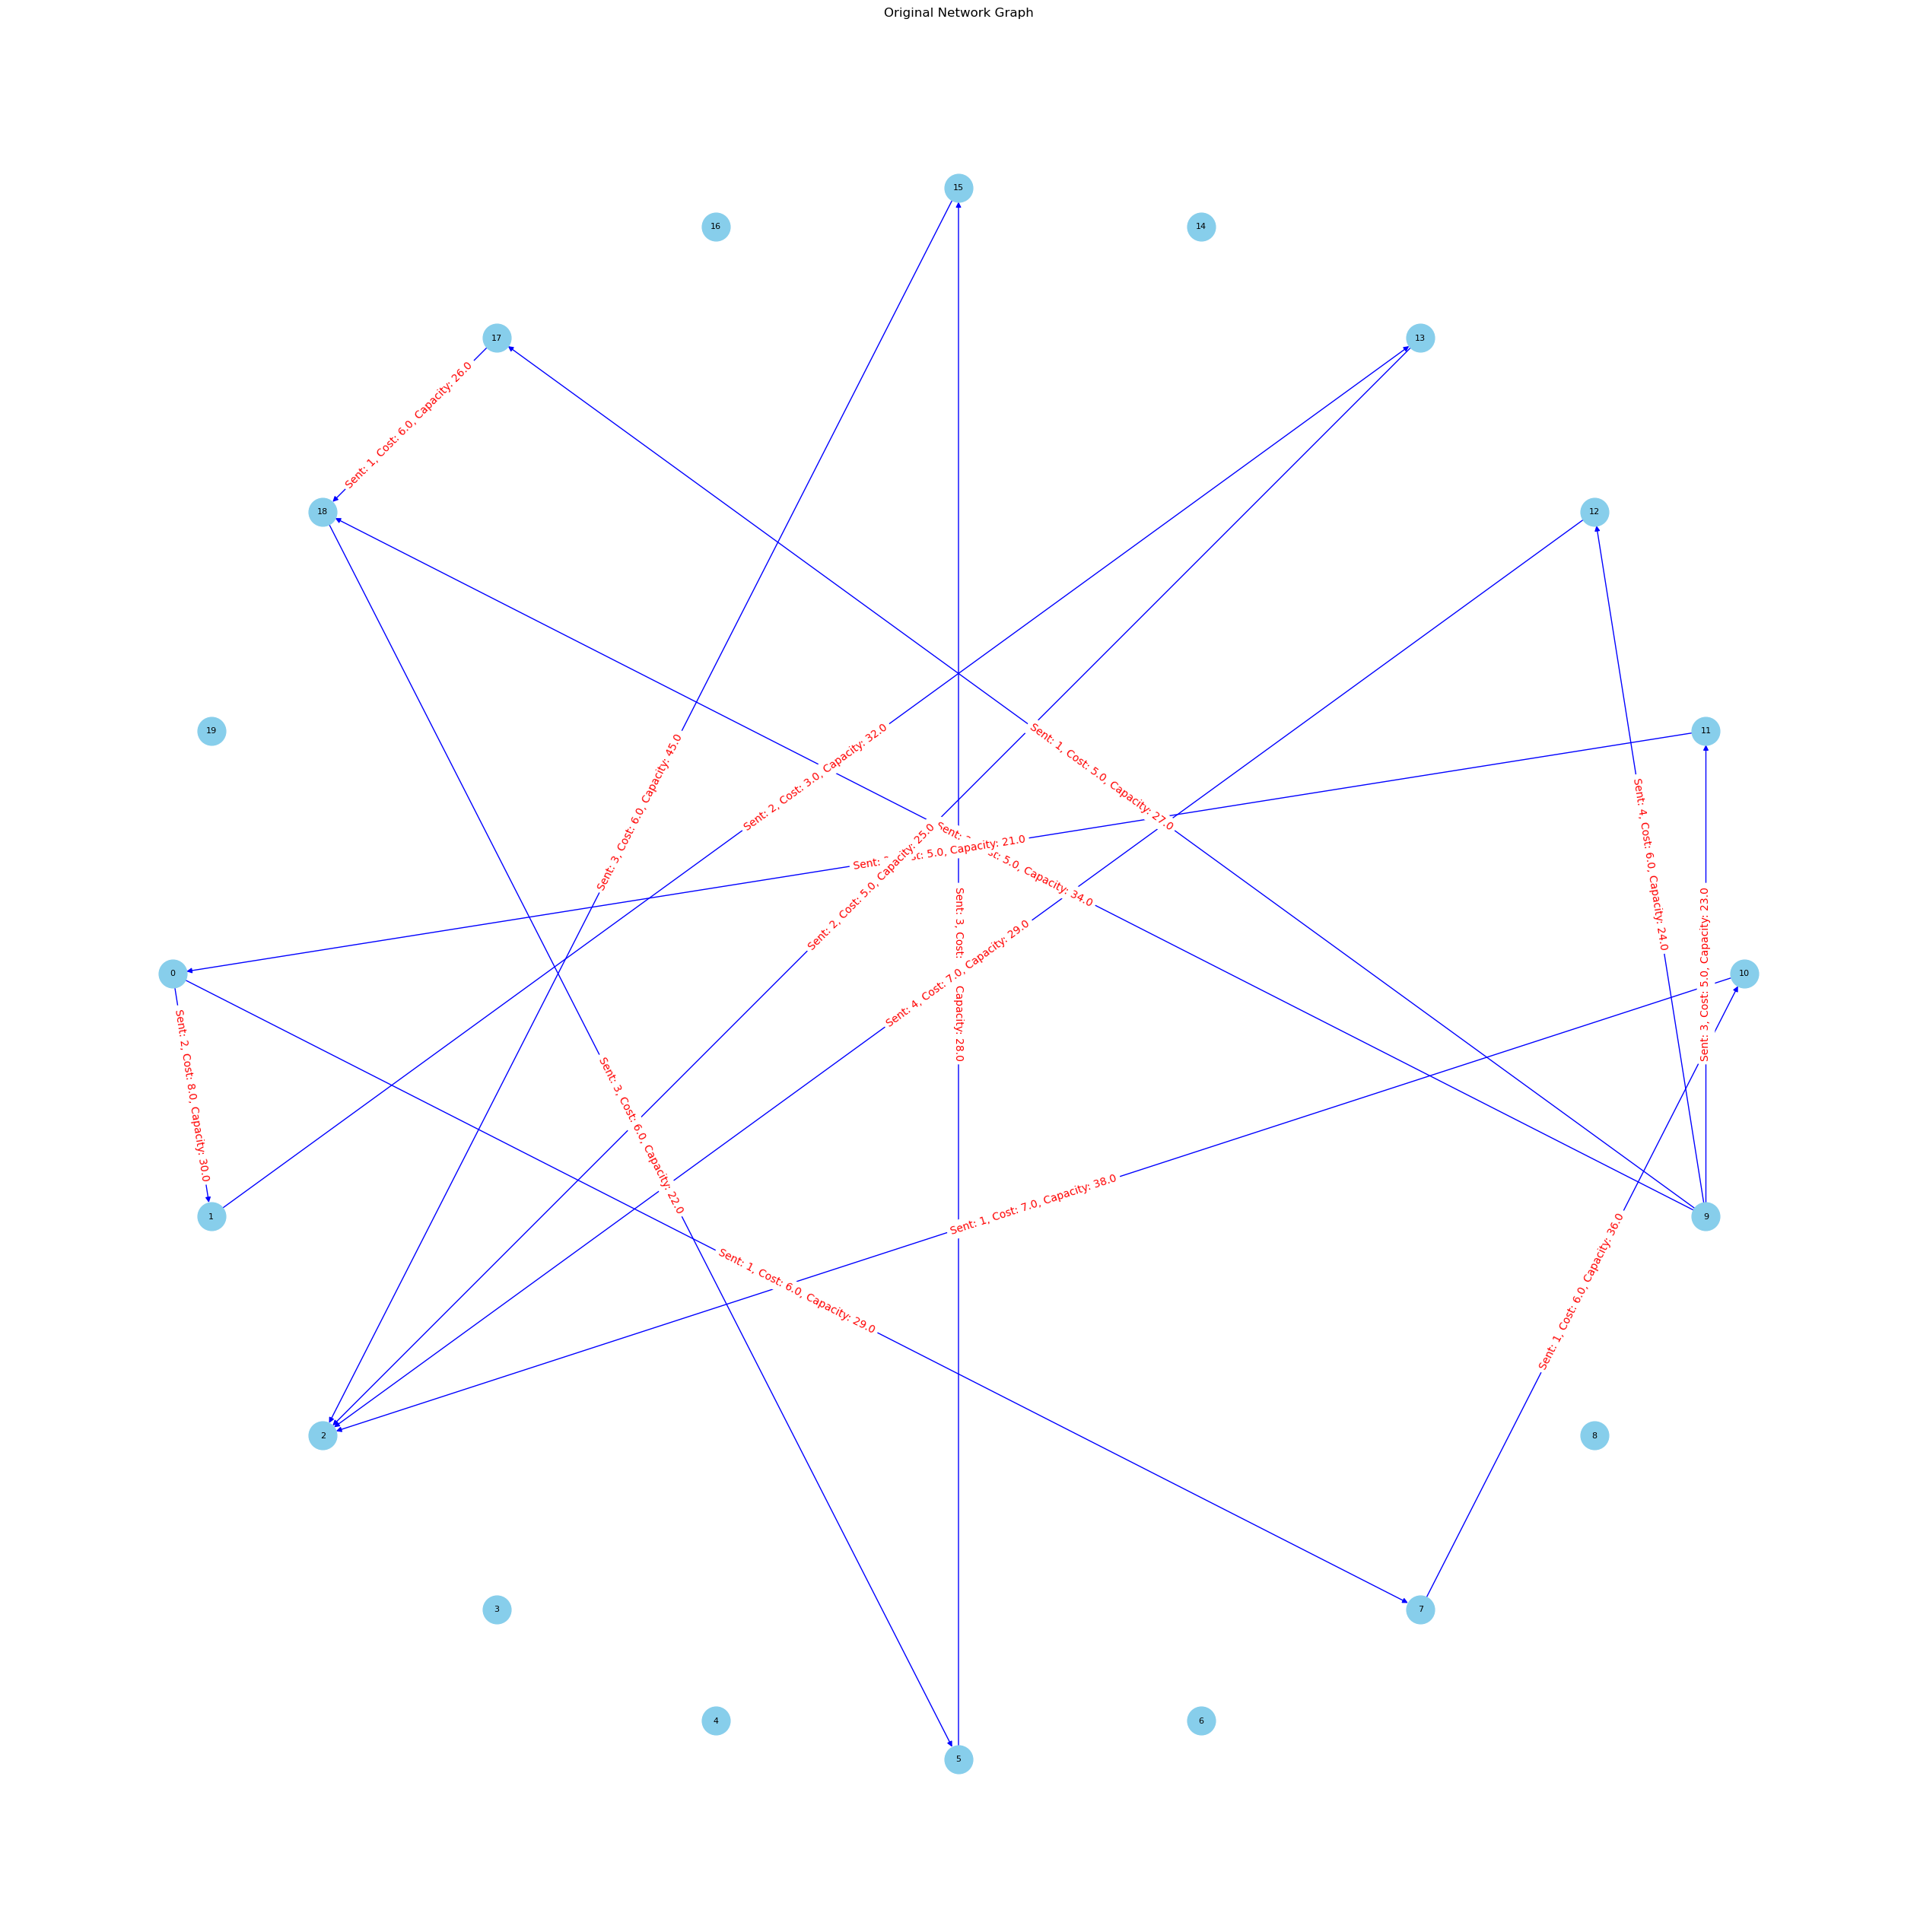

In [100]:
# Create a directed graph
G_optimized = nx.DiGraph()

# Add nodes to the graph
G_optimized.add_nodes_from(N)

# Add edges to the graph based on the matrix
for i in range(len(N)):
    for j in range(len(N)):
        optimized_flow = model.x[i, j].value
        packet_type = model.packet_type[i, j].value

        if optimized_flow != 0:  
            G_optimized.add_edge(N[i], N[j], optimized_flow=optimized_flow, packet_type=packet_type)

# Visualize the graph
pos = nx.shell_layout(G_optimized)

packet_type_colors = {
    '1.0': 'blue',
    '2.0': 'green',
}

labels_packet_type = nx.get_edge_attributes(G_optimized, 'packet_type')
edge_colors = [packet_type_colors[f"{labels_packet_type[i, j]}"] for i, j in labels_packet_type]

labels_optimized_flow = nx.get_edge_attributes(G_optimized, 'optimized_flow')
edge_labels = {(i, j): f"Sent: {labels_optimized_flow[i, j]:.0f}, Cost: {R[i, j, 1]}, Capacity: {R[i, j, 2]}" for i, j in labels_optimized_flow}

# Plot the optimized flow on the edges
plt.figure(figsize=(25, 25))  # Adjust the figure size here
nx.draw(G_optimized, pos, with_labels=True, node_size=700, node_color='skyblue', font_color='black', font_size=8, edge_color=edge_colors)
nx.draw_networkx_edge_labels(G_optimized, pos, edge_labels=edge_labels, font_color='red')

plt.title('Original Network Graph')
plt.show()